# Lab 4: Linear Regression and Clustering

## Young Bin Jo: (yjo10)

## Due: September 26, 2018 11:59 PM [Next Wednesday]

### Logistics

See the website.

### What You Will Need to Know For This Lab

* K-means clustering
* Vector Quantization
* Nearest Neighbors Classification
* Linear Regression

### Preamble (don't change this)

In [1]:
%pylab inline
import numpy as np
from sklearn import neighbors
from numpy import genfromtxt
import scipy.spatial.distance as dist
import random
from sklearn.cluster import KMeans
from PIL import Image
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


### Problem 1: Linear Regression (35 points)

In this problem, you will do model selection for linear regression using Ordinary Least Squares, Ridge Regression and the LASSO.

The dataset you will use has 8 features:

    lcavol - log cancer volume
    lcaweight - log prostate weight
    age
    lbph - log of amount of benign prostatic hyperplasia
    svi - seminal vesicle invasion
    lcp - log capsular penetration
    gleason - Gleason score
    pgg45 - percent of Gleason scores 4 or 5

and you will predict the level of a prostate-specific antigen. The data set was collected from a set of men about to receive a radical prostatectomy. More details are given in Section 3.2.1 in Elements of Statistical Learning 2e by Hastie et al.

In [2]:
# Load the data
trainp= genfromtxt('trainp.csv', delimiter=',')

# Training data: 
trainfeat=trainp[:,:-1] #Training features (rows are feature vectors)
trainresp=trainp[:,-1] #Training responses

valp= genfromtxt('valp.csv',delimiter=',')
# Validation data:
valfeat=valp[:,:-1] #Validation Features (rows are feature vectors)
valresp=valp[:,-1] #Validation Response

# Standardize and center the features
ftsclr=StandardScaler()
trainfeat = ftsclr.fit_transform(trainfeat)
valfeat= ftsclr.transform(valfeat)
# and the responses (note that the example in the notes has centered but not 
#                    standardized responses, so your numbers won't match up)
rsclr=StandardScaler()
trainresp = (rsclr.fit_transform(trainresp.reshape(-1,1))).reshape(-1)
valresp= (rsclr.transform(valresp.reshape(-1,1))).reshape(-1)

# The training features are in trainfeat
# The training responses are in trainresp
# The validation features are in valfeat
# The validation responses are in valresp

Since we centered the responses, we can begin with a benchmark model: Always predict the response as zero (mean response on the training data). Calculate the validation RSS for this model. **(5 points)**

If another model does worse than this, it is a sign that something is amiss.

Note: The RSS on a data set with $V$ samples is given by $\frac{1}{V} \lVert \mathbf{y} - \hat{\mathbf{y}} \rVert^2$ where $\mathbf{y}$ is a vector of the responses, and $\hat{\mathbf{y}}$ is the predicted responses on the data.

In [4]:
# Put your code here
col = trainfeat.shape[0]
row = trainfeat.shape[1]
V = valresp.size
print(1/V*sum((valresp)**2))

0.733852091912677


[RSS validation is 0.733852091912677]

First, you will try (Ordinary) Least Squares. Use `sklearn.linear_model.LinearRegression` with the default options. Calculate the validation RSS. <b>(5 points)</b>

Note: The .score() method returns an [$R^2$  value](https://en.wikipedia.org/wiki/Coefficient_of_determination), not the RSS, so you shouldn't use it anywhere in this problem. 

In [5]:
# Put your code here
reg = linear_model.LinearRegression()
reg.fit(trainfeat,trainresp)
pred_resp = reg.predict(valfeat)

V = valresp.size
print(1/V*sum((valresp-pred_resp)**2))

0.36230709903819786


[RSS validation is 0.36230709903819786]

Now, you will apply ridge regression with `sklearn.linear_model.Ridge`. 

Sweep the regularization/tuning parameter $\alpha=0,\ldots,100$ with 1000 equally spaced values. 

Make a plot of the RSS on the validation set versus $\alpha$. What is the minimizing $\alpha$, corresponding coefficients and validation error? 

Larger values of $\alpha$ shrink the weights in the model more. $\alpha=0$ corresponds to the LS solution. <b>(10 points)</b>

minimizingn Alpha:  12.3
corresponding Coefficients:  123
validation Error:  0.3384853737648543


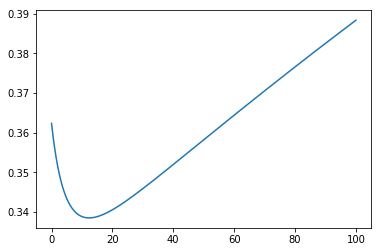

In [6]:
# Put your code here
alpha = arange(start=0,stop=100.1,step=0.1)
error = np.array([])

for a in alpha:
    clf = linear_model.Ridge(alpha = a)
    clf.fit(trainfeat, trainresp)
    
    predresp = clf.predict(valfeat)
    error = np.append(error, (1/(predresp.size)*sum((valresp-predresp)**2)))
               
print('minimizingn Alpha: ',alpha[np.argmin(error)])
print('corresponding Coefficients: ',np.argmin(error))
print('validation Error: ',np.min(error))

pylab.plot(alpha,error)

[minimizingn Alpha:  12.3 <br>
corresponding Coefficients:  123 <br>
validation Error:  0.3384853737648543]

Now, you will apply the LASSO with `sklearn.linear_model.Lasso`. 

Sweep the tuning/regularization parameter $\alpha=0,\ldots,1$ with 1000 equally spaced values. 

Make a plot of the RSS on the validation set versus $\alpha$. What is the minimizing $\alpha$, corresponding coefficients and validation error? 


Larger values of $\alpha$ lead to sparser solutions (i.e. less features used in the model), with a sufficiently large value of $\alpha$ leading to a constant prediction. Small values of $\alpha$ are closer to the LS solution, with $\alpha=0$ being the LS solution. <b>(10 points)</b>

In [ ]:
# Put your code here
alpha = arange(start=0,stop=1.001,step=0.001)
error = np.array([])

for a in alpha:
    clf = linear_model.Lasso(alpha = a)
    clf.fit(trainfeat, trainresp)
    
    predresp = clf.predict(valfeat)
    error = np.append(error, 1/(predresp.size)*sum((valresp-predresp)**2))
   
print('minimizing Alpha:', alpha[np.argmin(error)])
print('corresponding Coefficients:', np.argmin(error))
print('validation Error:', np.min(error))

pylab.plot(alpha,error)

[minimizing Alpha: 0.093 <br>
corresponding Coefficients: 93 <br>
validation Error: 0.31426491652065836]

Which features were selected by Ridge Regression when minimizing the RSS on the validation set? Which features were selected by LASSO when minimizing the RSS on the validation set? Which model would you choose (and why)? <b>(5 points)</b>

[I would choose LASSO since it has the lowest validation error. I have not found a right way to implement features]

### Problem 2: Selecting the number of clusters (30 points)

Write a function which implements K-means clustering. 

You will be given as input:
* A $(N,d)$ numpy.ndarray of unlabeled data (with each row as a feature vector), data
* A scalar $K$ which indicates the number of clusters
* A scalar representing the number of iterations, niter (this is your stopping criterion/criterion for convergence)

Your output will be a tuple consisting of a vector of length N containing which cluster ($0,\ldots,K-1$) a feature vector is in and a $(K,d)$ matrix with the rows containing the cluster centers. 

Do not use scikit-learn or similar for implement K-means clustering. You may use `scipy.spatial.distance.cdist` to calculate distances. Initialize the centers randomly without replacement with points from the data set. `random.sample` may be useful for this. <b>(10 points)</b>

In [ ]:
def kMeans(data,K,niter):
    #Put your code here
    centers  = random.sample(list(data), K)
    centers = numpy.array(centers)    
    labels = zeros((data.shape[0]))
    for n in range(niter):
        for i in range(data.shape[0]):
            distances = sqrt(sum((centers-data[i,:])**2,axis=1))
            labels[i] = argmin(distances)
        for i in range(K):
            new_center = data[labels==i,:].mean(axis=0)
            centers[i,:] = new_center

    return(labels, centers)

The K-means clustering problem tries to minimize the following quantity by selecting $\{z_i\}_{i=1}^N$ and $\{\mu_k\}_{k=1}^K$:
$$J_K(\{z_i\}_{i=1}^N ,\{\mu_k\}_{k=1}^K)=\sum_{i=1}^N \lVert \mathbf{x}_i - \mathbf{\mu}_{z_i} \rVert^2$$
where $\mathbf{\mu}_{z_i}$ is the center of the cluster to which $\mathbf{x}_i$ is assigned.

One visual heuristic to choose the number of clusters from the data (where the number of clusters is not known a priori) is to estimate the optimal value of $J_K(\{z_i\}_{i=1}^N ,\{\mu_k\}_{k=1}^K)$, $J^*(K)$ , for different values of $K$ and look for an "elbow" or "knee" in the curve of $J^*$ versus $K$ and choose that value of $K$. 

In this part of the problem, you will run $K$-means 100 times for each $K=2,\ldots,10$ and calculate $J_K(\{z_i\}_{i=1}^N ,\{\mu_k\}_{k=1}^K)$ for the clustering given by $K$-means. Use the smallest value of $J_K(\{z_i\}_{i=1}^N ,\{\mu_k\}_{k=1}^K)$ in the runs of $K$-means for each value of $K$ to form an estimate of $J^*(K)$. Plot this estimate versus $K$. Which $K$ should you pick by this heuristic? Use niter=100 for each run of $K$-means.

For an attempt to formalize this heuristic, see Tibshirani, Robert, Guenther Walther, and Trevor Hastie. "Estimating the number of clusters in a data set via the gap statistic." Journal of the Royal Statistical Society: Series B (Statistical Methodology) 63.2 (2001): 411-423. Sometimes, an elbow does not exist in the curve or there are multiple elbows or the $K$ value of an elbow cannot be unambiguously identified. Further material can be found on <a href="http://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_Elbow_Method">Wikipedia</a> as well.  

Note: Your code should be relatively quick -- a few minutes, at worst. <b>(10 points)</b>

In [ ]:
# Load up some data, which we will store in a variable called problem1
problem1= genfromtxt('problem1.csv', delimiter=',')

In [ ]:
# Put your code here
J = np.zeros(10)

for k in range(1,11):
    labels, centers = kMeans(problem1, k, 100)
    for i in range(problem1.shape[0]):
        difference = problem1[i,:] - centers[int(labels[i]),:]
        J[k-1] += sum((difference)**2)
  
plot(range(1,11),J)

[I would pick 4 for my K]

Using the value of $K$ you determined from the elbow, perform K-means clustering on the data. 
Plot it as a scatter plot with the colors given by the labels. <b>(5 points)</b>

In [ ]:
#Put your code here
labels, centers = kMeans(problem1, 4, 100)
scatter(problem1[:,0],problem1[:,1], c=labels)

Should you pick the $K$ such that $J^*(K)$ is minimized? Why or why not? <b>(5 points)</b>

[No. If J∗(K) is minized, it will be hard to catagorize or group data.]

### Problem 3: Vector Quantization (40 points)

In this problem, you will implement vector quantization. You will use `sklearn.cluster.KMeans` for the K-means implementation and use k-means++ as the initialization method. See Section 4.2.1 in the notes for details. 

Write a function to generate a codebook for vector quantization. You will be given inputs:
* A $(N,M)$ numpy.ndarray representing a greyscale image, called image. (If we want to generate our codebook from multiple images, we can concatenate the images before running them through this function).
* A scalar $B$, for which you will use $B \times B$ blocks for vector quantization. You may assume $N$ and $M$ are divisible by $B$.
* A scalar $K$, which is the size of your codebook

You will return:
* The codebook as a $(K,B^2)$ numpy.ndarray. 
<b>(10 points)</b>

In [ ]:
def trainVQ(image,B,K):
    #Put your code here
    N,M = image.shape
    row = N/B
    col = M/B
    index = 0
    location = np.zeros((int(row*col),int(B*B)))
    
    for row_ in range(int(row)):
        for col_ in range(int(col)):
            block = image[B*row_:B*row_+B,B*col_:B*col_+B]
            location[index,:] = block.reshape(int(B*B))
            index = index + 1
    
    kmeans = KMeans(n_clusters=K, random_state=0).fit(location)
    codebook = kmeans.cluster_centers_
    return codebook

Write a function which compresses an image against a given codebook. You will be given inputs:
* A $(N,M)$ numpy.ndarray representing a greyscale image, called image. You may assume $N$ and $M$ are divisible by $B$.
* A $(K,B^2)$ codebook called codebook
* $B$

You will return:
* A $(N/B,M/B)$ numpy.ndarray consisting of the indices in the codebook used to approximate the image. 

You can use the nearest neighbor classifier from scikit-learn if you want (though it is not necessary) to map blocks to their nearest codeword. <b>(10 points)</b>

In [ ]:
def compressImg(image, codebook,B):
    #Put your code here
    N, M = image.shape
    row = N/B
    col = M/B
    index = 0
    location = np.zeros((int(row*col),int(B*B)))

    for row_ in range(int(row)):
        for col_ in range(int(col)):
            block = image[B*row_:B*row_+B,B*col_:B*col_+B]
            location[index,:] = block.reshape(int(B*B))
            index = index + 1
    
    indices = zeros((int(row), int(col)))
    K_labels = np.arange(codebook.shape[0])
    index_2 = 0
    for row_ in range(int(row)):
        for col_ in range(int(col)):
            neigh = neighbors.KNeighborsClassifier(1)
            neigh.fit(codebook,K_labels)
            indices[row_, col_] = neigh.predict(location[index_2,:].reshape(1,-1))
            index_2 = index_2 + 1
            
    return indices

Write a function to reconstruct an image from its codebook. You will be given inputs:
* A $(N/B,M/B)$ numpy.ndarray containing the indices of the codebook for each block called indices
* A codebook as a $(K,B^2)$ numpy.ndarray called codebook
* $B$

You will return a $(N,M)$ numpy.ndarray representing the image. <b>(10 points)</b>

In [ ]:
def decompressImg(indices, codebook,B):
    #Put your code here
    row, col = indices.shape
    N = B*row
    M = B*col
    location = np.zeros((int(row*col),int(B*B))) #Initialize variables
    
    index = 0
    for row_ in range(int(row)):
        for col_ in range(int(col)):
            index_1 = int(indices[row_, col_])
            location[index,:] = codebook[index_1,:]
            index = index + 1
        
    image = np.zeros((N,M))    
    index_2 = 0
    for row_ in range(int(row)):
        for col_ in range(int(col)):
            r_start = B*row_
            block = location[index_2,:].reshape(B,B)
            image[B*row_:B*row_+B,B*col_:B*col_+B] = block
            index_2 = index_2 + 1
            
    return image

Run your vector quantizer with $5 \times 5$ blocks on the provided image with codebook sizes $K=2,5,10,20,50,100,200$ (i.e. generate codebooks from this image of those sizes, compress the image using those codebooks and reconstruct the images). Display and comment on the reconstructed images (you may be quantitative (e.g. PSNR) or qualitative). Which code book would you pick? Why? Make sure to take into account the bits per pixel used by the compressor.

Note the number of bits per pixel can be approximated as $\frac{\log_2 K}{25}$ and the codebook takes approximately $200K$ bits (assuming each pixel is stored as 8 bits). Some good ideas on quantitative arguments for codebook size can be found in Gonzalez & Woods, Digital Image Processing 3e or Gersho & Gray, Signal Compression & Vector Quantization. It is not necessary to look at these references for quantitative arguments, though. <b>(10 points)</b>

The image used is under fair use from [FIFA](https://www.fifa.com/worldcup/news/france-revel-winning-second-world-title-2986453).

In [ ]:
# The provided image is stored in image
image = np.asarray(Image.open("mrtb.jpg").convert("L"))
imshow(image, cmap = cm.Greys_r)

In [ ]:
#Put your code here
for k in [2,5,10,20,50,100,200]:
    codebook = trainVQ(image, 5, k)
    indices = compressImg(image, codebook, 5)
    images = decompressImg(indices, codebook, 5)
    figure()
    imshow(images, cmap = cm.Greys_r)

[I would choose k = 100 since it has clear pixel. It has 0.266 bpp. If k increases, it has clearer image which means it takes longer for compression and decompression. Therefore considering image quality and time, I would pick K = 100]

### Problem 4: Using K-means to Accelerate Nearest Neighbors (20 points)

In this problem, you will use K-means clustering to accelerate nearest neighbors, as outlined in the notes (Algorithm 7). Use `sklearn.neighbors.KNeighborsClassifier` for nearest neighbor classification and `sklearn.cluster.KMeans` for the K-means implementation with k-means++ as the initialization method.

You will write a function to generate prototypes from labeled data. It will have input:
* Training features as $(N,d)$ numpy.ndarray called traindata
* Training labels as a length $N$ vector called trainlabels
* $K$, the number of prototypes under each class

You will return a tuple containing:
* The prototypes selected as a $(K*\text{number of classes},d)$ numpy.ndarray
* The corresponding labels as a $K*\text{number of classes}$ length vector 

You may assume there are at least $K$ examples under each class. `set(trainlabels)` will give you the set of labels. <b>(10 points)</b>

In [ ]:
def generatePrototypes(traindata,trainlabels,K):
      # Put your code here
    numclasses = len(set(trainlabels))
    prototypes = np.zeros((K * numclasses, traindata.shape[1]))
    labels = np.zeros(K * numclasses)
    
    for i in set(trainlabels):
        kmeans = KMeans(n_clusters=K, random_state=0).fit(traindata[trainlabels == i])
        prototypes[int(i*K):int((i+1)*K)] = kmeans.cluster_centers_
        labels[int(i*K):int((i+1)*K)] = i
    
    return prototypes, labels

Train a nearest neighbor classifier (i.e. 1-NN)  with 1,10,50,100 and 200 prototypes per class for the digits data set from Lab 2. Comment on the validation error and computational complexity versus the nearest neighbor classifier from Lab 2 (error=0.056) and the LDA classifier (error=0.115) from Lab 2. Which classifier would you pick? Why? 

Note that this data set is generated from zip code digits from US mail, and the US Postal Service processes <a href="https://about.usps.com/who-we-are/postal-facts/one-day-by-the-numbers.htm">hundreds of millions of pieces of mail</a> a day, so a small improvement in error can lead to tremendous savings in terms of mis-routed packages (which cost a lot of money and time to re-transport). <b>(10 points)</b>

In [ ]:
# Load the digits data set

#Read in the Training Data
traindata_tmp= genfromtxt('zip.train', delimiter=' ')
#The training labels are stored in "trainlabels", training features in "traindata"
trainlabels=traindata_tmp[:,0]
traindata=traindata_tmp[:,1:]


#Read in the Validation Data
valdata_tmp= genfromtxt('zip.val', delimiter=' ')
#The validation labels are stored in "vallabels", validation features in "valdata"
vallabels=valdata_tmp[:,0]
valdata=valdata_tmp[:,1:]


In [ ]:
# Put your code here
for k in [1,10,50,100,200]:
    prototypes, labels = generatePrototypes(traindata,trainlabels,k)
    neigh = neighbors.KNeighborsClassifier(n_neighbors = 1)
    neigh.fit(prototypes, labels)
    error = 1 - neigh.score(valdata, vallabels)
    print('K=',k,'validation error:',error)

[I would choose nearest neighbor classifier from lab2. The error rate was the lowest among three. ]

## And this concludes Lab 4! 